In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

In [14]:
import torch
from torch import nn, optim
from jcopdl.callback import Callback, set_config

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [3]:
df = pd.read_csv("data/daily_min_temp.csv", index_col="Date", parse_dates=["Date"])
df.head()

,Temp
Date,
1981-01-01,20.7
1981-01-02,17.9
1981-01-03,18.8
1981-01-04,14.6
1981-01-05,15.8


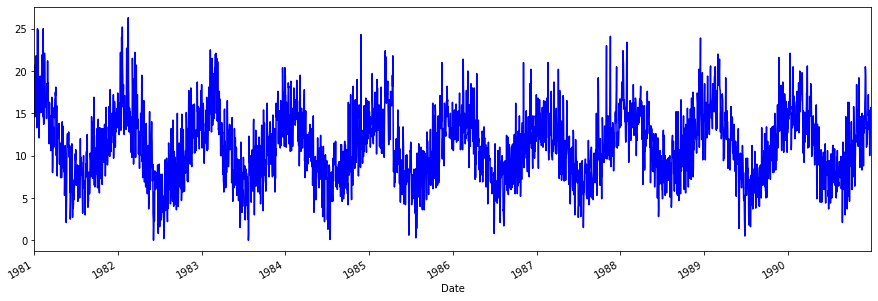

In [5]:
df.Temp.plot(figsize=(15, 5), color='b')

## Dataset Splitting

In [7]:
# X = df.Temp
# y = df.Temp

ts_train, ts_test = train_test_split(df, test_size=0.2, shuffle=False)
ts_train.shape, ts_test.shape

((2920, 1), (730, 1))

## Dataset & Dataloader

In [8]:
from jcopdl.utils.dataloader import TimeSeriesDataset
from torch.utils.data import DataLoader

In [13]:
seq_len = 14
bs = 32

train_set = TimeSeriesDataset(ts_train, "Temp", seq_len)
trainloader = DataLoader(train_set, batch_size=bs)

test_set = TimeSeriesDataset(ts_test, "Temp", seq_len)
testloader = DataLoader(test_set, batch_size=bs)

(N, S, F): (208, 14, 1)
Note: last 7 data excluded

(N, S, F): (52, 14, 1)
Note: last 1 data excluded



## Arsitektur & Config

In [26]:
class RNN(nn.Module):
    def __init__(self, input_size, output_size, hidden_size, num_layers, dropout):
        super().__init__()
        
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, dropout=dropout, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x, hidden):
        x, hidden = self.rnn(x, hidden)
        x = self.fc(x)
        return x, hidden
        

In [27]:
config = set_config({
    "input_size": train_set.n_feature,
    "seq_len": train_set.n_seq,
    "output_size": 1,
    "hidden_size": 64,
    "num_layers": 2,
    "dropout": 0
})

## Training Preparation -> MCOC

In [31]:
model = RNN(config.input_size, config.output_size, config.hidden_size, config.num_layers, config.dropout).to(device)
criterion = nn.MSELoss(reduction="mean")
optimizer = optim.AdamW(model.parameters(), lr=0.001)
callback = Callback(model, config, outdir="model/rnn")

## Training

In [32]:
from tqdm.auto import tqdm

def loop_fn(mode, dataset, dataloader, model, criterion, optimizer, device):
    if mode == "train":
        model.train()
    elif mode == "test":
        model.eval()
    cost = 0
    for feature, target in tqdm(dataloader, desc=mode.title()):
        feature, target = feature.to(device), target.to(device)
        output, hidden = model(feature, None)
        loss = criterion(output, target)
        
        if mode == "train":
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        cost += loss.item() * feature.shape[0]
    cost = cost / len(dataset)
    return cost



Epoch     1
Train_cost  = 129.8713 | Test_cost  = 116.8768 | 




Epoch     2
Train_cost  = 99.6738 | Test_cost  = 93.3324 | 




Epoch     3
Train_cost  = 80.6471 | Test_cost  = 78.4061 | 




Epoch     4
Train_cost  = 68.2476 | Test_cost  = 67.9294 | 




Epoch     5
Train_cost  = 59.3356 | Test_cost  = 59.9745 | 




Epoch     6
Train_cost  = 52.3936 | Test_cost  = 53.4430 | 




Epoch     7
Train_cost  = 46.6309 | Test_cost  = 47.8848 | 




Epoch     8
Train_cost  = 41.7173 | Test_cost  = 43.0795 | 




Epoch     9
Train_cost  = 37.4900 | Test_cost  = 38.9215 | 




Epoch    10
Train_cost  = 33.8621 | Test_cost  = 35.3395 | 




Epoch    11
Train_cost  = 30.7662 | Test_cost  = 32.2700 | 




Epoch    12
Train_cost  = 28.1409 | Test_cost  = 29.6537 | 




Epoch    13
Train_cost  = 25.9292 | Test_cost  = 27.4360 | 




Epoch    14
Train_cost  = 24.0784 | Test_cost  = 25.5664 | 




Epoch    15
Train_cost  = 22.5402 | Test_cost  = 23.9989 | 




Epoch    16
Train_cost  = 21.2709 | Test_cost  = 22.6917 | 




Epoch    17
Train_cost  = 20.2311 | Test_cost  = 21.6075 | 




Epoch    18
Train_cost  = 19.3855 | Test_cost  = 20.7127 | 




Epoch    19
Train_cost  = 18.7030 | Test_cost  = 19.9780 | 




Epoch    20
Train_cost  = 18.1562 | Test_cost  = 19.3774 | 


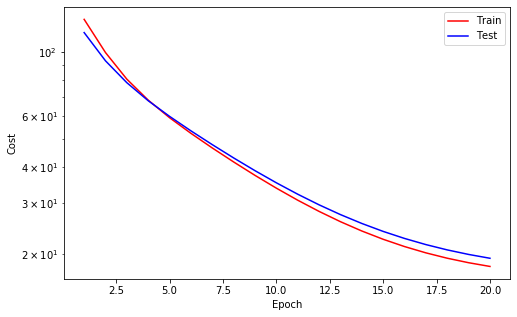



Epoch    21
Train_cost  = 17.7213 | Test_cost  = 18.8885 | 




Epoch    22
Train_cost  = 17.3780 | Test_cost  = 18.4920 | 




Epoch    23
Train_cost  = 17.1089 | Test_cost  = 18.1715 | 




Epoch    24
Train_cost  = 16.8994 | Test_cost  = 17.9130 | 




Epoch    25
Train_cost  = 16.7373 | Test_cost  = 17.7049 | 




Epoch    26
Train_cost  = 16.6126 | Test_cost  = 17.5375 | 




Epoch    27
Train_cost  = 16.5171 | Test_cost  = 17.4029 | 




Epoch    28
Train_cost  = 16.4442 | Test_cost  = 17.2946 | 




Epoch    29
Train_cost  = 16.3886 | Test_cost  = 17.2074 | 




Epoch    30
Train_cost  = 16.3462 | Test_cost  = 17.1369 | 




Epoch    31
Train_cost  = 16.3137 | Test_cost  = 17.0796 | 




Epoch    32
Train_cost  = 16.2885 | Test_cost  = 17.0330 | 




Epoch    33
Train_cost  = 16.2687 | Test_cost  = 16.9947 | 




Epoch    34
Train_cost  = 16.2528 | Test_cost  = 16.9629 | 




Epoch    35
Train_cost  = 16.2396 | Test_cost  = 16.9363 | 




Epoch    36
Train_cost  = 16.2281 | Test_cost  = 16.9135 | 




Epoch    37
Train_cost  = 16.2176 | Test_cost  = 16.8936 | 




Epoch    38
Train_cost  = 16.2073 | Test_cost  = 16.8756 | 




Epoch    39
Train_cost  = 16.1966 | Test_cost  = 16.8584 | 




Epoch    40
Train_cost  = 16.1845 | Test_cost  = 16.8408 | 


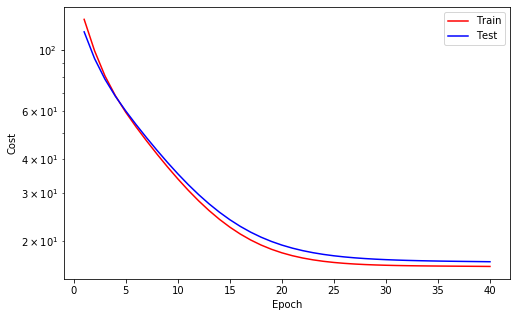



Epoch    41
Train_cost  = 16.1695 | Test_cost  = 16.8207 | 




Epoch    42
Train_cost  = 16.1488 | Test_cost  = 16.7934 | 




Epoch    43
Train_cost  = 16.1145 | Test_cost  = 16.7441 | 




Epoch    44
Train_cost  = 16.0322 | Test_cost  = 16.6060 | 




Epoch    45
Train_cost  = 15.8346 | Test_cost  = 16.3947 | 




Epoch    46
Train_cost  = 15.3299 | Test_cost  = 15.2798 | 




Epoch    47
Train_cost  = 14.0742 | Test_cost  = 14.0951 | 




Epoch    48
Train_cost  = 13.1068 | Test_cost  = 13.4752 | 




Epoch    49
Train_cost  = 12.4949 | Test_cost  = 12.5949 | 




Epoch    50
Train_cost  = 11.8141 | Test_cost  = 11.8769 | 




Epoch    51
Train_cost  = 11.3023 | Test_cost  = 11.2912 | 




Epoch    52
Train_cost  = 10.8009 | Test_cost  = 10.8155 | 




Epoch    53
Train_cost  = 10.4346 | Test_cost  = 10.3605 | 




Epoch    54
Train_cost  = 10.0909 | Test_cost  = 9.9351 | 




Epoch    55
Train_cost  = 9.7507 | Test_cost  = 9.5590 | 




Epoch    56
Train_cost  = 9.4748 | Test_cost  = 9.2365 | 




Epoch    57
Train_cost  = 9.2584 | Test_cost  = 8.9500 | 




Epoch    58
Train_cost  = 9.0632 | Test_cost  = 8.6917 | 




Epoch    59
Train_cost  = 8.8729 | Test_cost  = 8.4655 | 




Epoch    60
Train_cost  = 8.7013 | Test_cost  = 8.2689 | 


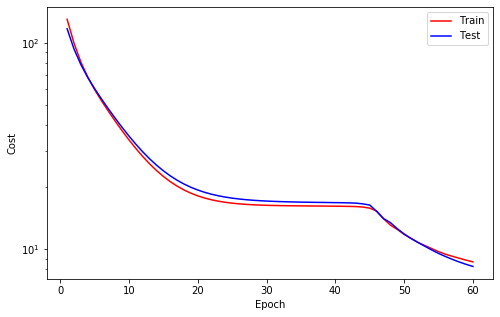



Epoch    61
Train_cost  = 8.5545 | Test_cost  = 8.0911 | 




Epoch    62
Train_cost  = 8.4219 | Test_cost  = 7.9240 | 




Epoch    63
Train_cost  = 8.2939 | Test_cost  = 7.7700 | 




Epoch    64
Train_cost  = 8.1712 | Test_cost  = 7.6305 | 




Epoch    65
Train_cost  = 8.0575 | Test_cost  = 7.5027 | 




Epoch    66
Train_cost  = 7.9535 | Test_cost  = 7.3845 | 




Epoch    67
Train_cost  = 7.8577 | Test_cost  = 7.2746 | 




Epoch    68
Train_cost  = 7.7685 | Test_cost  = 7.1722 | 




Epoch    69
Train_cost  = 7.6858 | Test_cost  = 7.0771 | 




Epoch    70
Train_cost  = 7.6100 | Test_cost  = 6.9888 | 




Epoch    71
Train_cost  = 7.5403 | Test_cost  = 6.9062 | 




Epoch    72
Train_cost  = 7.4760 | Test_cost  = 6.8288 | 




Epoch    73
Train_cost  = 7.4163 | Test_cost  = 6.7561 | 




Epoch    74
Train_cost  = 7.3608 | Test_cost  = 6.6878 | 




Epoch    75
Train_cost  = 7.3089 | Test_cost  = 6.6236 | 




Epoch    76
Train_cost  = 7.2604 | Test_cost  = 6.5631 | 




Epoch    77
Train_cost  = 7.2149 | Test_cost  = 6.5063 | 




Epoch    78
Train_cost  = 7.1721 | Test_cost  = 6.4527 | 




Epoch    79
Train_cost  = 7.1317 | Test_cost  = 6.4022 | 




Epoch    80
Train_cost  = 7.0934 | Test_cost  = 6.3546 | 


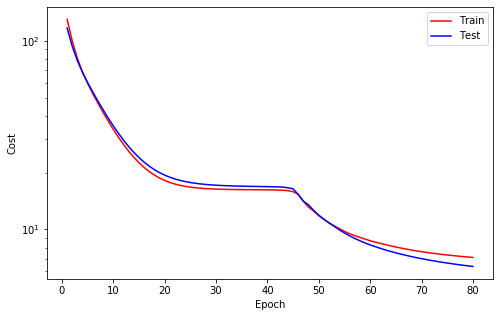



Epoch    81
Train_cost  = 7.0572 | Test_cost  = 6.3097 | 




Epoch    82
Train_cost  = 7.0229 | Test_cost  = 6.2672 | 




Epoch    83
Train_cost  = 6.9903 | Test_cost  = 6.2271 | 




Epoch    84
Train_cost  = 6.9595 | Test_cost  = 6.1892 | 




Epoch    85
Train_cost  = 6.9302 | Test_cost  = 6.1532 | 




Epoch    86
Train_cost  = 6.9025 | Test_cost  = 6.1192 | 




Epoch    87
Train_cost  = 6.8761 | Test_cost  = 6.0869 | 




Epoch    88
Train_cost  = 6.8510 | Test_cost  = 6.0562 | 




Epoch    89
Train_cost  = 6.8271 | Test_cost  = 6.0271 | 




Epoch    90
Train_cost  = 6.8044 | Test_cost  = 5.9993 | 




Epoch    91
Train_cost  = 6.7827 | Test_cost  = 5.9729 | 




Epoch    92
Train_cost  = 6.7619 | Test_cost  = 5.9477 | 




Epoch    93
Train_cost  = 6.7421 | Test_cost  = 5.9237 | 




Epoch    94
Train_cost  = 6.7231 | Test_cost  = 5.9008 | 




Epoch    95
Train_cost  = 6.7049 | Test_cost  = 5.8788 | 




Epoch    96
Train_cost  = 6.6874 | Test_cost  = 5.8578 | 




Epoch    97
Train_cost  = 6.6706 | Test_cost  = 5.8377 | 




Epoch    98
Train_cost  = 6.6545 | Test_cost  = 5.8184 | 




Epoch    99
Train_cost  = 6.6389 | Test_cost  = 5.7998 | 




Epoch   100
Train_cost  = 6.6239 | Test_cost  = 5.7820 | 


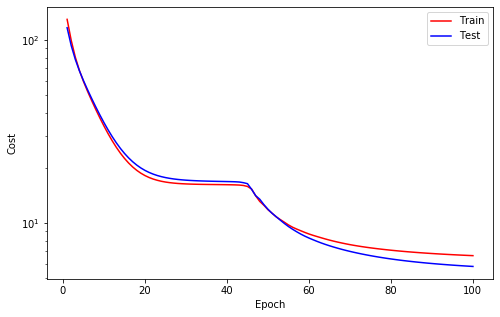



Epoch   101
Train_cost  = 6.6094 | Test_cost  = 5.7649 | 




Epoch   102
Train_cost  = 6.5955 | Test_cost  = 5.7484 | 




Epoch   103
Train_cost  = 6.5819 | Test_cost  = 5.7325 | 




Epoch   104
Train_cost  = 6.5688 | Test_cost  = 5.7172 | 




Epoch   105
Train_cost  = 6.5561 | Test_cost  = 5.7024 | 




Epoch   106
Train_cost  = 6.5438 | Test_cost  = 5.6882 | 




Epoch   107
Train_cost  = 6.5318 | Test_cost  = 5.6745 | 




Epoch   108
Train_cost  = 6.5202 | Test_cost  = 5.6612 | 




Epoch   109
Train_cost  = 6.5089 | Test_cost  = 5.6484 | 




Epoch   110
Train_cost  = 6.4979 | Test_cost  = 5.6361 | 




Epoch   111
Train_cost  = 6.4872 | Test_cost  = 5.6241 | 




Epoch   112
Train_cost  = 6.4767 | Test_cost  = 5.6126 | 




Epoch   113
Train_cost  = 6.4666 | Test_cost  = 5.6015 | 




Epoch   114
Train_cost  = 6.4566 | Test_cost  = 5.5907 | 




Epoch   115
Train_cost  = 6.4469 | Test_cost  = 5.5804 | 




Epoch   116
Train_cost  = 6.4375 | Test_cost  = 5.5704 | 




Epoch   117
Train_cost  = 6.4282 | Test_cost  = 5.5607 | 




Epoch   118
Train_cost  = 6.4192 | Test_cost  = 5.5514 | 




Epoch   119
Train_cost  = 6.4103 | Test_cost  = 5.5424 | 




Epoch   120
Train_cost  = 6.4016 | Test_cost  = 5.5337 | 


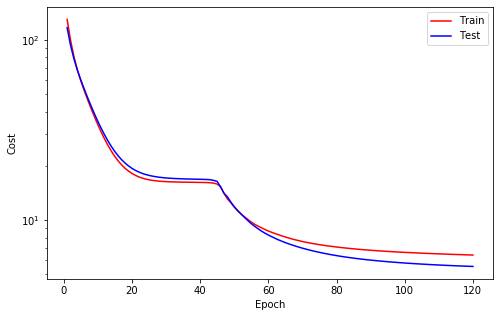



Epoch   121
Train_cost  = 6.3931 | Test_cost  = 5.5254 | 




Epoch   122
Train_cost  = 6.3848 | Test_cost  = 5.5173 | 




Epoch   123
Train_cost  = 6.3766 | Test_cost  = 5.5095 | 




Epoch   124
Train_cost  = 6.3686 | Test_cost  = 5.5020 | 




Epoch   125
Train_cost  = 6.3607 | Test_cost  = 5.4947 | 




Epoch   126
Train_cost  = 6.3530 | Test_cost  = 5.4877 | 




Epoch   127
Train_cost  = 6.3454 | Test_cost  = 5.4809 | 




Epoch   128
Train_cost  = 6.3379 | Test_cost  = 5.4744 | 




Epoch   129
Train_cost  = 6.3306 | Test_cost  = 5.4681 | 




Epoch   130
Train_cost  = 6.3233 | Test_cost  = 5.4620 | 




Epoch   131
Train_cost  = 6.3162 | Test_cost  = 5.4561 | 




Epoch   132
Train_cost  = 6.3092 | Test_cost  = 5.4504 | 




Epoch   133
Train_cost  = 6.3024 | Test_cost  = 5.4449 | 




Epoch   134
Train_cost  = 6.2956 | Test_cost  = 5.4396 | 




Epoch   135
Train_cost  = 6.2889 | Test_cost  = 5.4344 | 




Epoch   136
Train_cost  = 6.2823 | Test_cost  = 5.4294 | 




Epoch   137
Train_cost  = 6.2759 | Test_cost  = 5.4245 | 




Epoch   138
Train_cost  = 6.2695 | Test_cost  = 5.4197 | 




Epoch   139
Train_cost  = 6.2632 | Test_cost  = 5.4151 | 




Epoch   140
Train_cost  = 6.2570 | Test_cost  = 5.4106 | 


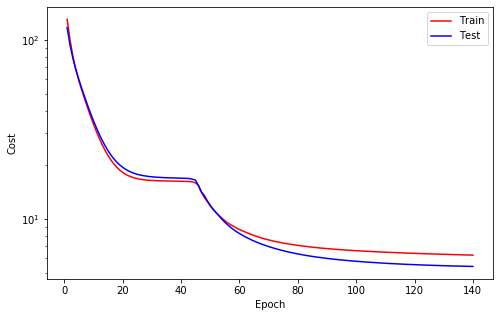



Epoch   141
Train_cost  = 6.2509 | Test_cost  = 5.4061 | 




Epoch   142
Train_cost  = 6.2449 | Test_cost  = 5.4018 | 




Epoch   143
Train_cost  = 6.2389 | Test_cost  = 5.3976 | 




Epoch   144
Train_cost  = 6.2331 | Test_cost  = 5.3934 | 




Epoch   145
Train_cost  = 6.2273 | Test_cost  = 5.3893 | 




Epoch   146
Train_cost  = 6.2216 | Test_cost  = 5.3853 | 




Epoch   147
Train_cost  = 6.2159 | Test_cost  = 5.3814 | 




Epoch   148
Train_cost  = 6.2103 | Test_cost  = 5.3776 | 




Epoch   149
Train_cost  = 6.2048 | Test_cost  = 5.3738 | 




Epoch   150
Train_cost  = 6.1993 | Test_cost  = 5.3701 | 




Epoch   151
Train_cost  = 6.1939 | Test_cost  = 5.3665 | 




Epoch   152
Train_cost  = 6.1886 | Test_cost  = 5.3630 | 




Epoch   153
Train_cost  = 6.1832 | Test_cost  = 5.3595 | 




Epoch   154
Train_cost  = 6.1780 | Test_cost  = 5.3562 | 




Epoch   155
Train_cost  = 6.1727 | Test_cost  = 5.3529 | 




Epoch   156
Train_cost  = 6.1675 | Test_cost  = 5.3497 | 




Epoch   157
Train_cost  = 6.1624 | Test_cost  = 5.3466 | 




Epoch   158
Train_cost  = 6.1572 | Test_cost  = 5.3436 | 




Epoch   159
Train_cost  = 6.1521 | Test_cost  = 5.3407 | 




Epoch   160
Train_cost  = 6.1470 | Test_cost  = 5.3378 | 


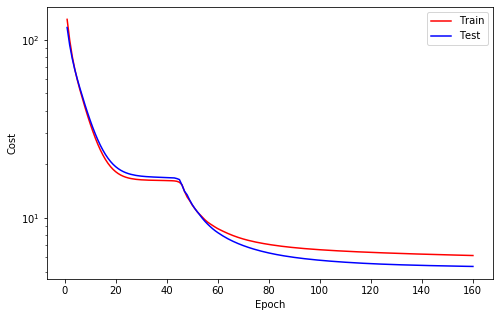



Epoch   161
Train_cost  = 6.1419 | Test_cost  = 5.3351 | 




Epoch   162
Train_cost  = 6.1369 | Test_cost  = 5.3324 | 




Epoch   163
Train_cost  = 6.1318 | Test_cost  = 5.3298 | 




Epoch   164
Train_cost  = 6.1268 | Test_cost  = 5.3273 | 




Epoch   165
Train_cost  = 6.1217 | Test_cost  = 5.3249 | 




Epoch   166
Train_cost  = 6.1167 | Test_cost  = 5.3225 | 




Epoch   167
Train_cost  = 6.1116 | Test_cost  = 5.3202 | 




Epoch   168
Train_cost  = 6.1066 | Test_cost  = 5.3180 | 




Epoch   169
Train_cost  = 6.1015 | Test_cost  = 5.3159 | 




Epoch   170
Train_cost  = 6.0964 | Test_cost  = 5.3138 | 




Epoch   171
Train_cost  = 6.0913 | Test_cost  = 5.3118 | 




Epoch   172
Train_cost  = 6.0862 | Test_cost  = 5.3099 | 




Epoch   173
Train_cost  = 6.0811 | Test_cost  = 5.3080 | 




Epoch   174
Train_cost  = 6.0759 | Test_cost  = 5.3061 | 




Epoch   175
Train_cost  = 6.0707 | Test_cost  = 5.3043 | 




Epoch   176
Train_cost  = 6.0655 | Test_cost  = 5.3025 | 




Epoch   177
Train_cost  = 6.0602 | Test_cost  = 5.3007 | 




Epoch   178
Train_cost  = 6.0549 | Test_cost  = 5.2989 | 




Epoch   179
Train_cost  = 6.0496 | Test_cost  = 5.2972 | 




Epoch   180
Train_cost  = 6.0443 | Test_cost  = 5.2955 | 


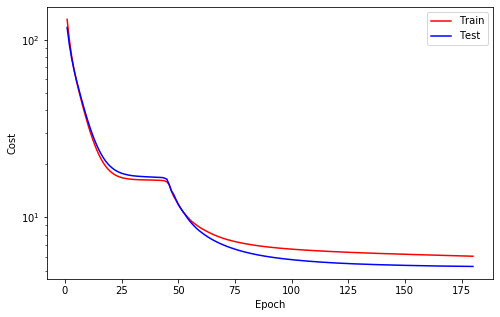



Epoch   181
Train_cost  = 6.0389 | Test_cost  = 5.2937 | 




Epoch   182
Train_cost  = 6.0335 | Test_cost  = 5.2920 | 




Epoch   183
Train_cost  = 6.0280 | Test_cost  = 5.2903 | 




Epoch   184
Train_cost  = 6.0226 | Test_cost  = 5.2886 | 




Epoch   185
Train_cost  = 6.0171 | Test_cost  = 5.2869 | 




Epoch   186
Train_cost  = 6.0116 | Test_cost  = 5.2851 | 




Epoch   187
Train_cost  = 6.0060 | Test_cost  = 5.2834 | 




Epoch   188
Train_cost  = 6.0005 | Test_cost  = 5.2816 | 




Epoch   189
Train_cost  = 5.9949 | Test_cost  = 5.2799 | 




Epoch   190
Train_cost  = 5.9893 | Test_cost  = 5.2781 | 




Epoch   191
Train_cost  = 5.9837 | Test_cost  = 5.2764 | 




Epoch   192
Train_cost  = 5.9781 | Test_cost  = 5.2748 | 




Epoch   193
Train_cost  = 5.9724 | Test_cost  = 5.2732 | 




Epoch   194
Train_cost  = 5.9667 | Test_cost  = 5.2717 | 




Epoch   195
Train_cost  = 5.9610 | Test_cost  = 5.2703 | 




Epoch   196
Train_cost  = 5.9553 | Test_cost  = 5.2691 | 




Epoch   197
Train_cost  = 5.9495 | Test_cost  = 5.2680 | 




Epoch   198
Train_cost  = 5.9437 | Test_cost  = 5.2672 | 




Epoch   199
Train_cost  = 5.9379 | Test_cost  = 5.2666 | 




Epoch   200
Train_cost  = 5.9321 | Test_cost  = 5.2663 | 


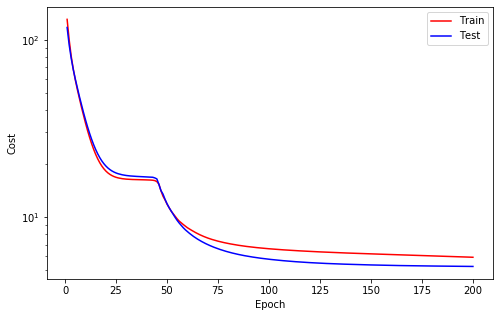



Epoch   201
Train_cost  = 5.9262 | Test_cost  = 5.2662 | 




Epoch   202
Train_cost  = 5.9204 | Test_cost  = 5.2664 | 
==> EarlyStop patience =  1 | Best test_cost: 5.2662




Epoch   203
Train_cost  = 5.9145 | Test_cost  = 5.2668 | 
==> EarlyStop patience =  2 | Best test_cost: 5.2662




Epoch   204
Train_cost  = 5.9086 | Test_cost  = 5.2674 | 
==> EarlyStop patience =  3 | Best test_cost: 5.2662




Epoch   205
Train_cost  = 5.9027 | Test_cost  = 5.2683 | 
==> EarlyStop patience =  4 | Best test_cost: 5.2662




Epoch   206
Train_cost  = 5.8969 | Test_cost  = 5.2693 | 
==> EarlyStop patience =  5 | Best test_cost: 5.2662
==> Execute Early Stopping at epoch: 206 | Best test_cost: 5.2662
==> Best model is saved at model/rnn


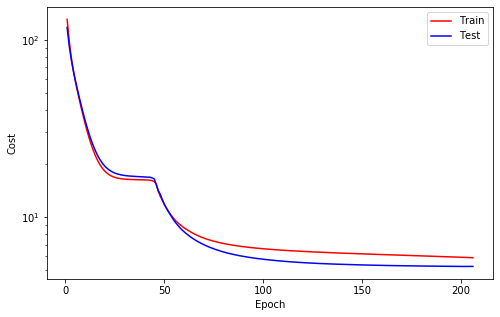

In [33]:
while True:
    train_cost = loop_fn("train", train_set, trainloader, model, criterion, optimizer, device)
    with torch.no_grad():
        test_cost = loop_fn("test", test_set, testloader, model, criterion, optimizer, device)
    
    # Logging
    callback.log(train_cost, test_cost)

    # Checkpoint
    callback.save_checkpoint()
        
    # Runtime Plotting
    callback.cost_runtime_plotting()
    
    # Early Stopping
    if callback.early_stopping(model, monitor="test_cost"):
        callback.plot_cost()
        break

## Sanity Check

In [34]:
from luwiji.rnn import illustration

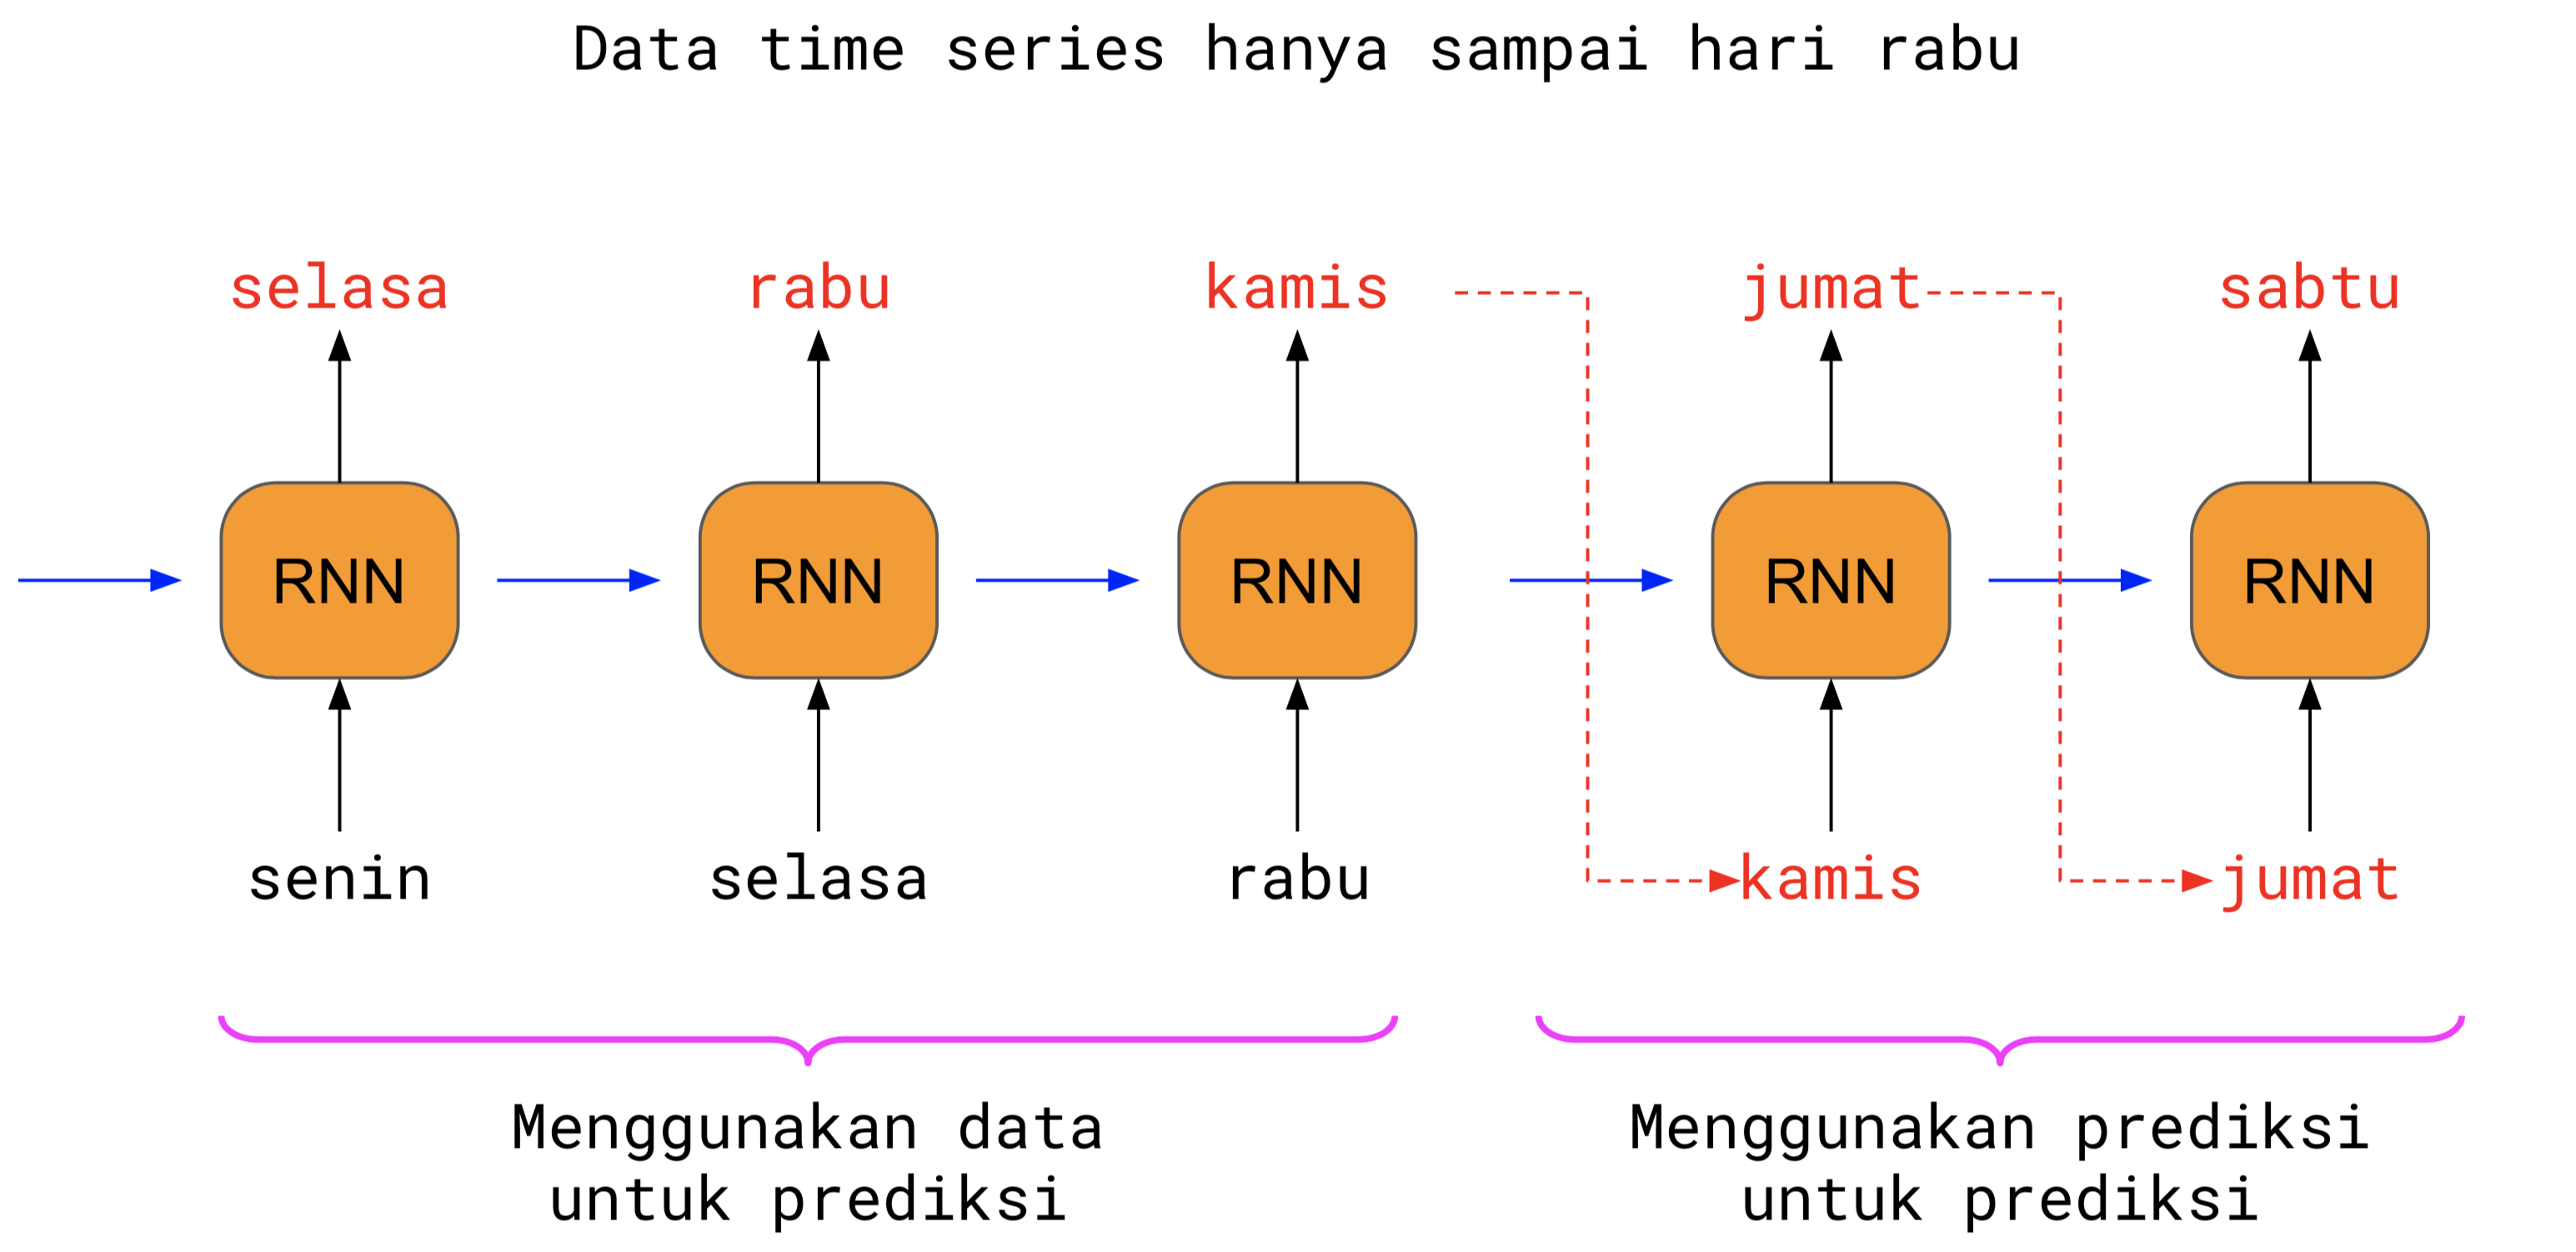

In [35]:
illustration.forecast

In [36]:
from utils import data4pred, pred4pred

In [37]:
train_forecast_set = TimeSeriesDataset(ts_train, "Temp", 1)
trainforecastloader = DataLoader(train_forecast_set)
test_forecast_set = TimeSeriesDataset(ts_test, "Temp", 1)
testforecastloader = DataLoader(test_forecast_set)

(N, S, F): (2919, 1, 1)
Note: last 0 data excluded

(N, S, F): (729, 1, 1)
Note: last 0 data excluded



Text(0.5, 1.0, 'Test')

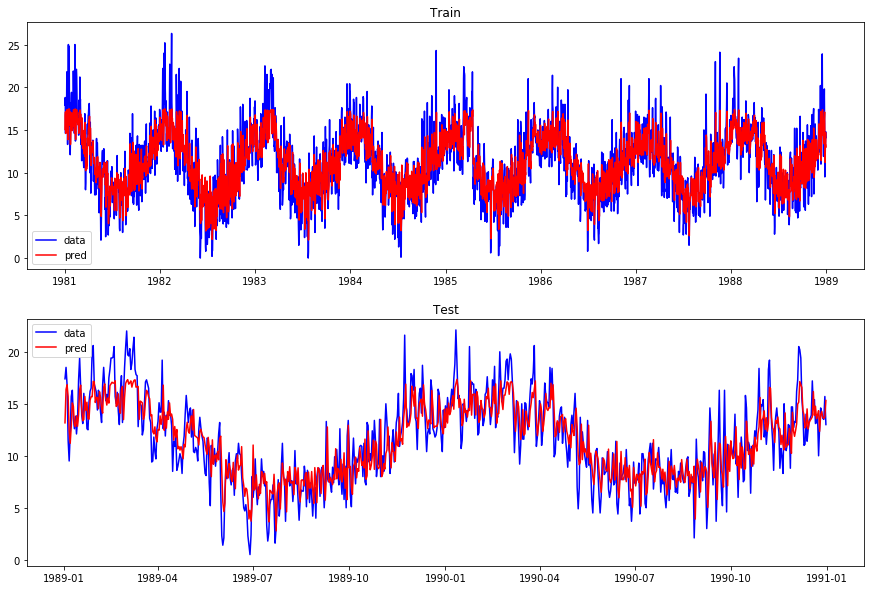

In [38]:
plt.figure(figsize=(15, 10))

plt.subplot(211)
data4pred(model, train_forecast_set, trainforecastloader, device)
plt.title("Train")

plt.subplot(212)
data4pred(model, test_forecast_set, testforecastloader, device)
plt.title("Test")

Text(0.5, 1.0, 'test')

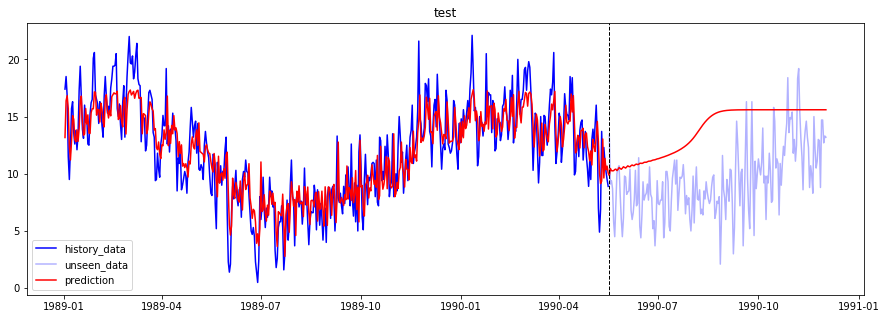

In [39]:
#Pred 4 pred
plt.figure(figsize=(15, 5))
pred4pred(model, test_forecast_set, testforecastloader, device)
plt.title("test")